# This notebook is used to plot figure 1 of epistasis paper by randomly sampling a gene sets from pairs for each gene

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import gc
from scipy.stats.stats import pearsonr
from itertools import combinations
import random
import multiprocessing
import concurrent.futures
import string
random.seed(1234)

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/epistasis_codes/mutex_data

/content/drive/.shortcut-targets-by-id/1M7ksQHsnBabT6t_aAy6H6k_JHTqvUBjb/epistasis_codes/mutex_data


## IntAct

In [4]:
inpath_intact = '../mutex_data/'
intact_edge_file = inpath_intact+'intact_nodupl_edge_file.txt'
intact_index_file = inpath_intact+'intact_nodupl_index_file.txt'

with open(intact_index_file, 'r') as f:
    indices = {line.split()[0]:line.split()[1] for line in f.readlines()}

with open(intact_edge_file, 'r') as f:
    edges = [(indices[line.split()[0]].upper(),indices[line.split()[1]].upper()) for line in f.readlines()]
len(edges)

intact_genes_list = list(indices.values())
intact_genes_list[:5]

['""CHEBI', '100147744', '1B', '1EFV', '1KLA']

## COSMIC

In [5]:
inpath_cosmic = '../mutex_data/'
cosmic_infile = inpath_cosmic+'Census_allFri_Apr_26_12_49_57_2019.tsv'
with open(cosmic_infile,'r') as f:
    cosmic_genes = [line.split()[0].upper() for line in f.readlines()[1:]]
print(len(cosmic_genes))
# cosmic_genes

723


## Functions

In [6]:
def set_input_file_paths(methods, c, t):
    '''set input paths as per the location of the MEX results
    m:methods, c: cancer type, t: threshold'''
    
    strat_list=['COADREAD']
    dict_infile = {}
    dict_infile_intact = {}
    for m in methods:
        if m == 'discover':
            suffix = '{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_q1.0_normal_{}.txt'.format(m,c,m,t)
            suffix_intact = '{}_mutation_filtered_ep_data/{}_pairs_q1.0_normal_intact_filtered_subset{}.txt'.format(m,c,t)
        elif m == 'discover_strat':
            suffix = '{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_q1.0_stratified_{}.txt'.format('discover',c,'discover',t)
            suffix_intact = '{}_mutation_filtered_ep_data/{}_pairs_q1.0_stratified_intact_filtered_subset{}.txt'.format('discover',c,t)    
        else:
            suffix = '{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_{}.txt'.format(m,c,m,t)
            suffix_intact = '{}_mutation_filtered_ep_data/{}_{}_pairs_intact_filtered_subset{}.txt'.format(m,c,m,t)

        dict_infile[m] = '../mutex_data/' + suffix
        dict_infile_intact[m] = '../mutex_data/' + suffix_intact
    
    return dict_infile, dict_infile_intact

def load_cgcg_pairs(methods,dict_infile, ref_genes=cosmic_genes):
    '''
    load mutual exclusivity values for CGC-CGC pairs
    methods: mutual exclusivity methods, ref_genes=reference driver genes (COSMIC)
    '''
    d_out ={}
    for m in tqdm(methods):
        d_nb={}
        infile=dict_infile[m]
        with open(infile) as f: #dosyayı açtı
            for line in tqdm(f.readlines()): #tek tek okuma
                line=line.split()
                g1=line[1] #gene 1
                g2=line[2] #gene 2
                if g1 in ref_genes and g2 in ref_genes: #if gen1 and gen2 both cosmic genes
                    if g1 not in d_nb: 
                        d_nb[g1]={} 
                    if g2 not in d_nb:
                        d_nb[g2]={}
                    d_nb[g1][g2]=float(line[3])
                    d_nb[g2][g1]=float(line[3])
        d_out[m]=d_nb

    return d_out

def get_sig_dict(d,m):
    '''get percentage significance from a dictionary of CGC-CGC neighbors
    '''
    d_out={}
    for g in d:
        count=0
        for k,v in d[g].items():
            if m=='wext' and v==0:
                continue
            elif v<0.05:
                count+=1
        d_out[g]= float(count)/float(len(d[g]))
    return d_out
                
def get_sig_dict_from_random_sampling(d,d_nb,method):
    '''get percentage significance through random sampling
    '''
    common_genes = set.intersection(set(d), set(d_nb))
    dict_sig = {}
    for g in common_genes:
        l_temp=[]
        for i in range(100):
            k_temp = {k:d[g][k] for k in random.sample(list(d[g]),k=len(d_nb[g]))}
            
            count=0
            for k,v in k_temp.items():
                if method=='wext' and v==0:
                    continue
                elif v<0.05:
                    count+=1
            
            l_temp.append(float(count)/len(k_temp))
        
        dict_sig[g] = np.mean(l_temp)
    
    return dict_sig

def plot_from_dict(d, d_mla,ax, annotation_threshold_y=-0.0,annotation_threhsold_x=1.5,title=''):
    l_mla_all = []
    l_sig_all = []
    
    l_mla_nonrare = []
    l_sig_nonrare = []
    
    l_mla_rare = []
    l_sig_rare = []
    
    for k,v in d.items():
        if k in d_mla:
            l_mla_all.append(d_mla[k])
            l_sig_all.append(v)
            
                
    ax.scatter(l_mla_all,l_sig_all, c='K',alpha=0.3)
    
    r,p = pearsonr(l_mla_all,l_sig_all)
    print('r:{}\nP:{}'.format(r,p))
    ax.text(0.85, 0.97, 'r = {}\nP = {:.3g}'.format(round(r,2), p), ha='left', va='top', fontsize=8,transform=ax.transAxes)
    
    for k,v in d.items():
        if v>annotation_threshold_y and d_mla[k]<annotation_threhsold_x:
            ax.annotate(k, (d_mla[k],v), ha='left',va='top',xytext=(d_mla[k]+0.08,v-0.01))
    
#     ax.set_xlim(min(l_mla_all)-0.5,max(l_mla_all)+0.5)
    ax.set_xlim(min_mla-0.5,max_mla+0.5)
    ax.set_ylim(-0.05,1.05)        
    labels = [str(int(round(float(item)*100))) for item in ax.get_yticks()]
    print(labels)
    
    ax.set_yticklabels(labels)
    ax.set_xlabel('Mutation Load Association (MLA)')
    ax.set_ylabel('Percentage of Significant Findings (P<0.05)')
    ax.set_title(title)# + '| {} total genes, {} rare, {} nonrare'.format(len(l_sig_all), len(l_sig_rare),len(l_sig_nonrare)) )
    
        
    
def plot_from_dict_arrow(d,d_nb, d_mla,ax, annotation_threshold_y=-0.0,annotation_threhsold_x=1.5,title='',c1='C3',c2='K'):
    '''plot with direction of arrow going from dict d to dict d_nb
    annotation thresholds define the points until which gene annotation 
    is done in the graph 
    '''
    
    l_mla_all = []
    l_sig_all = []
    l_sig_nb = []
    
    
    for k,v in d.items():
        if k in d_mla and k in d_nb:
            l_mla_all.append(d_mla[k])
            l_sig_all.append(v)
            l_sig_nb.append(d_nb[k])
                
    ax.scatter(l_mla_all,l_sig_nb, c=c1,alpha=0.7)
    ax.scatter(l_mla_all,l_sig_all, c=c2,alpha=0.2)
    
    
    r,p = pearsonr(l_mla_all,l_sig_nb)
    print('r:{}\nP:{}'.format(r,p))
    ax.text(0.85, 0.97, 'r = {}\nP = {:.3g}'.format(round(r,2), p), ha='left', va='top', fontsize=8,transform=ax.transAxes)
    
    for k,v in d_nb.items():
        if v>annotation_threshold_y and d_mla[k]<annotation_threhsold_x:
            ax.annotate(k, (d_mla[k],v), ha='left',va='top',xytext=(d_mla[k]+0.08,v-0.01))
            
            
    for _mla,_all,_nb in zip(l_mla_all, l_sig_all,l_sig_nb):
        if _mla<annotation_threhsold_x and abs(_all-_nb)>0.01:
            if _all<_nb:
                ax.annotate("", xytext=(_mla, _all), xy=(_mla, _all+_nb-_all), arrowprops=dict(arrowstyle="->", alpha=0.2))
#                 ax.arrow(_mla,_all,0.0,_nb-_all, alpha=0.5,lw=2, length_includes_head=True)
#                 ax.quiver(_mla,_all,0.0,(_all-_nb), alpha=0.5,lw=0.1,headwidth=0.05, headlength=0.1,)
            else:
                ax.annotate("", xytext=(_mla, _all), xy=(_mla, _all+_nb-_all), arrowprops=dict(arrowstyle="->", alpha=0.2))
#                 ax.arrow(_mla,_all,0.0,_nb-_all, alpha=0.5,lw=2, length_includes_head=True)

#     for k,v in d.items():
#         if k in d_nb:
#             if d_mla[k]<annotation_threhsold_x:
#                 ax.arrow(d_mla[k], v, d_mla[k],d_nb[k])
            
        #     ax.arrow(l_mla_all[0],l_sig_all[0],l_sig_all[0]-l_sig_nb[0], l_mla_all[0]-l_mla_all[0],
#             shape='full', color='K', lw=1/2., length_includes_head=True, 
#             zorder=0)
#     ax.set_xlim(min(l_mla_all)-0.5,max(l_mla_all)+0.5)
    ax.set_xlim(min_mla-0.5,max_mla+0.5)
    ax.set_ylim(-0.05,1.05)        
    labels = [str(int(round(float(item)*100))) for item in ax.get_yticks()]

    ax.set_yticklabels(labels)        
    ax.set_xlabel('Mutation Load Association (MLA)')
    ax.set_ylabel('Percentage of Significant Findings (P<0.05)')
    ax.set_title(title)# + '| {} total genes, {} rare, {} nonrare'.format(len(l_sig_all), len(l_sig_rare),len(l_sig_nonrare)) )
    

def get_mla_limits(d_y,d_x):
    ''' get max and min MLA for same x axis
        d_y: sig values
        d_x: MLA values
    '''
    l = []
    for k,v in d_y.items():
        if k in d_x:
            l.append(d_x[k])
    
    return max(l), min(l)
            

## LOAD MUTEX VALUES

In [ ]:
c='UCEC' # cancer type
t=20 #mutation threshold
#methods = ['discover','discover_strat','fishers','wext']#'discover_strat','discover','discover_strat']#
methods = ['discover','fishers','wext']#'discover_strat','discover','discover_strat']#
inpath_mla = '../mutex_data/'

# inpath_sig = '../out_main/evaluation_results/significance_files/{}_t{}/'.format(c,t)


## Load MLA
MLA_infile = inpath_mla + 'MLA_ep_mutation_filtered_all_genes/{}_MLA_standardized.txt'.format(c)
with open(MLA_infile, 'r') as f:
    MLA = {line.split()[0]: float(line.split()[1]) for line in f.readlines()}
    
    
dict_infile, dict_infile_intact = set_input_file_paths(methods, c,t)

dict_cg_cg = load_cgcg_pairs(methods,dict_infile)
dict_cg_cg_nb = load_cgcg_pairs(methods,dict_infile_intact)

In [29]:
#PSF Values for each method: smethods[0]= discover methods[1]=fishers... accordingly
d_sig_m = get_sig_dict(dict_cg_cg[methods[3]], methods[3])
d_sig_m

{'ABL2': 0.09523809523809523,
 'ACVR2A': 0.08928571428571429,
 'AFF3': 0.10119047619047619,
 'AFF4': 0.02976190476190476,
 'AKAP9': 0.047619047619047616,
 'ALK': 0.10714285714285714,
 'AMER1': 0.27976190476190477,
 'ANK1': 0.05952380952380952,
 'APC': 0.9345238095238095,
 'AR': 0.21428571428571427,
 'ARHGAP5': 0.08928571428571429,
 'ARHGEF10': 0.06547619047619048,
 'ARID1A': 0.10119047619047619,
 'ARID1B': 0.05357142857142857,
 'ARID2': 0.08333333333333333,
 'ASXL1': 0.06547619047619048,
 'ASXL2': 0.07142857142857142,
 'ATM': 0.10714285714285714,
 'ATP2B3': 0.21428571428571427,
 'ATR': 0.10119047619047619,
 'ATRX': 0.10119047619047619,
 'AXIN2': 0.2619047619047619,
 'B2M': 0.125,
 'BCL9': 0.10119047619047619,
 'BCL9L': 0.25,
 'BCLAF1': 0.09523809523809523,
 'BCOR': 0.125,
 'BCORL1': 0.23809523809523808,
 'BIRC6': 0.05952380952380952,
 'BRAF': 0.10119047619047619,
 'BRCA2': 0.07738095238095238,
 'BRD4': 0.3869047619047619,
 'CACNA1D': 0.06547619047619048,
 'CAMTA1': 0.22023809523809523,

In [40]:
#saving PSF and MLA values for each gene
if c=='COADREAD' or c=='BRCA': #we have 4 method
  for i in range(4): #0,1,2,3
    d_sig_m = get_sig_dict(dict_cg_cg[methods[i]], methods[i])
    header= ("Gene"+'\t'+"PSF"+'\t'+"MLA")

    with open("./{}_percent_sig_findings_{}_t{}.txt".format(methods[i],c,t), 'a') as F: #add header
      F.write(header + "\n")
      F.close

    with open("./{}_percent_sig_findings_{}_t{}.txt".format(methods[i],c,t), 'a') as F: #add data
      for g in d_sig_m:
        if g in MLA:
          F.write(str(g) + '\t' + str(d_sig_m[g]) + '\t' + str(MLA[g])+'\n')
          #F.close

else: #for other cancer types we have 3 methods
  for i in range(3): #0,1,2
    d_sig_m = get_sig_dict(dict_cg_cg[methods[i]], methods[i])
    header= ("Gene"+'\t'+"PSF"+'\t'+"MLA")

    with open("./{}_percent_sig_findings_{}_t{}.txt".format(methods[i],c,t), 'a') as F: #add header
      F.write(header + "\n")
      F.close

    with open("./{}_percent_sig_findings_{}_t{}.txt".format(methods[i],c,t), 'a') as F: #add data
      for g in d_sig_m:
        if g in MLA:
          F.write(str(g) + '\t' + str(d_sig_m[g]) + '\t' + str(MLA[g])+'\n')
          #F.close

'''d_sig_m = get_sig_dict(dict_cg_cg[methods[0]], methods[0])
header= ("Gene"+'\t'+"PSF"+'\t'+"MLA")

with open("./{}_percent_sig_findings_{}_t{}.txt".format(methods,c,t), 'a') as F:
    F.write(header + "\n")
    F.close

with open("./{}_percent_sig_findings_{}_t{}.txt".format(methods,c,t), 'a') as F:
  for g in d_sig_m:
    if g in MLA:
      F.write(str(g) + '\t' + str(d_sig_m[g]) + '\t' + str(MLA[g])+'\n')

#d_sig_m
#df=pd.DataFrame(d_sig_m,index=[0]).T
#df.to_csv('./percent_sig_findings_{}_t{}.txt'.format(c,t), sep='\t', na_rep="none") '''


'd_sig_m = get_sig_dict(dict_cg_cg[methods[0]], methods[0])\nheader= ("Gene"+\'\t\'+"PSF"+\'\t\'+"MLA")\n\nwith open("./{}_percent_sig_findings_{}_t{}.txt".format(methods,c,t), \'a\') as F:\n    F.write(header + "\n")\n    F.close\n\nwith open("./{}_percent_sig_findings_{}_t{}.txt".format(methods,c,t), \'a\') as F:\n  for g in d_sig_m:\n    if g in MLA:\n      F.write(str(g) + \'\t\' + str(d_sig_m[g]) + \'\t\' + str(MLA[g])+\'\n\')\n\n#d_sig_m\n#df=pd.DataFrame(d_sig_m,index=[0]).T\n#df.to_csv(\'./percent_sig_findings_{}_t{}.txt\'.format(c,t), sep=\'\t\', na_rep="none") '

r:-0.8217866163838357
P:1.1995102901787974e-42
['-20', '0', '20', '40', '60', '80', '100', '120']
r:-0.8766082532965823
P:1.4287603659597569e-24
['-20', '0', '20', '40', '60', '80', '100', '120']
r:-0.3952658667667799
P:0.0004914006213622005
r:-0.7158042365777186
P:7.724143540636134e-28
r:-0.7191273377740228
P:5.334200055452931e-13
r:-0.3601530396532246
P:0.0016221190039977411
r:-0.5783242931328667
P:1.8108603104676567e-16
['-20', '0', '20', '40', '60', '80', '100', '120']
r:-0.6933248539688636
P:7.581903588964803e-12
['-20', '0', '20', '40', '60', '80', '100', '120']
r:-0.13129359259219597
P:0.2648346111094779
r:-0.8676323618119282
P:1.4871991049691715e-52
['-20', '0', '20', '40', '60', '80', '100', '120']
r:-0.9097128352451895
P:3.3809131310021267e-29
['-20', '0', '20', '40', '60', '80', '100', '120']
r:-0.3944689613063668
P:0.0005056546496535029



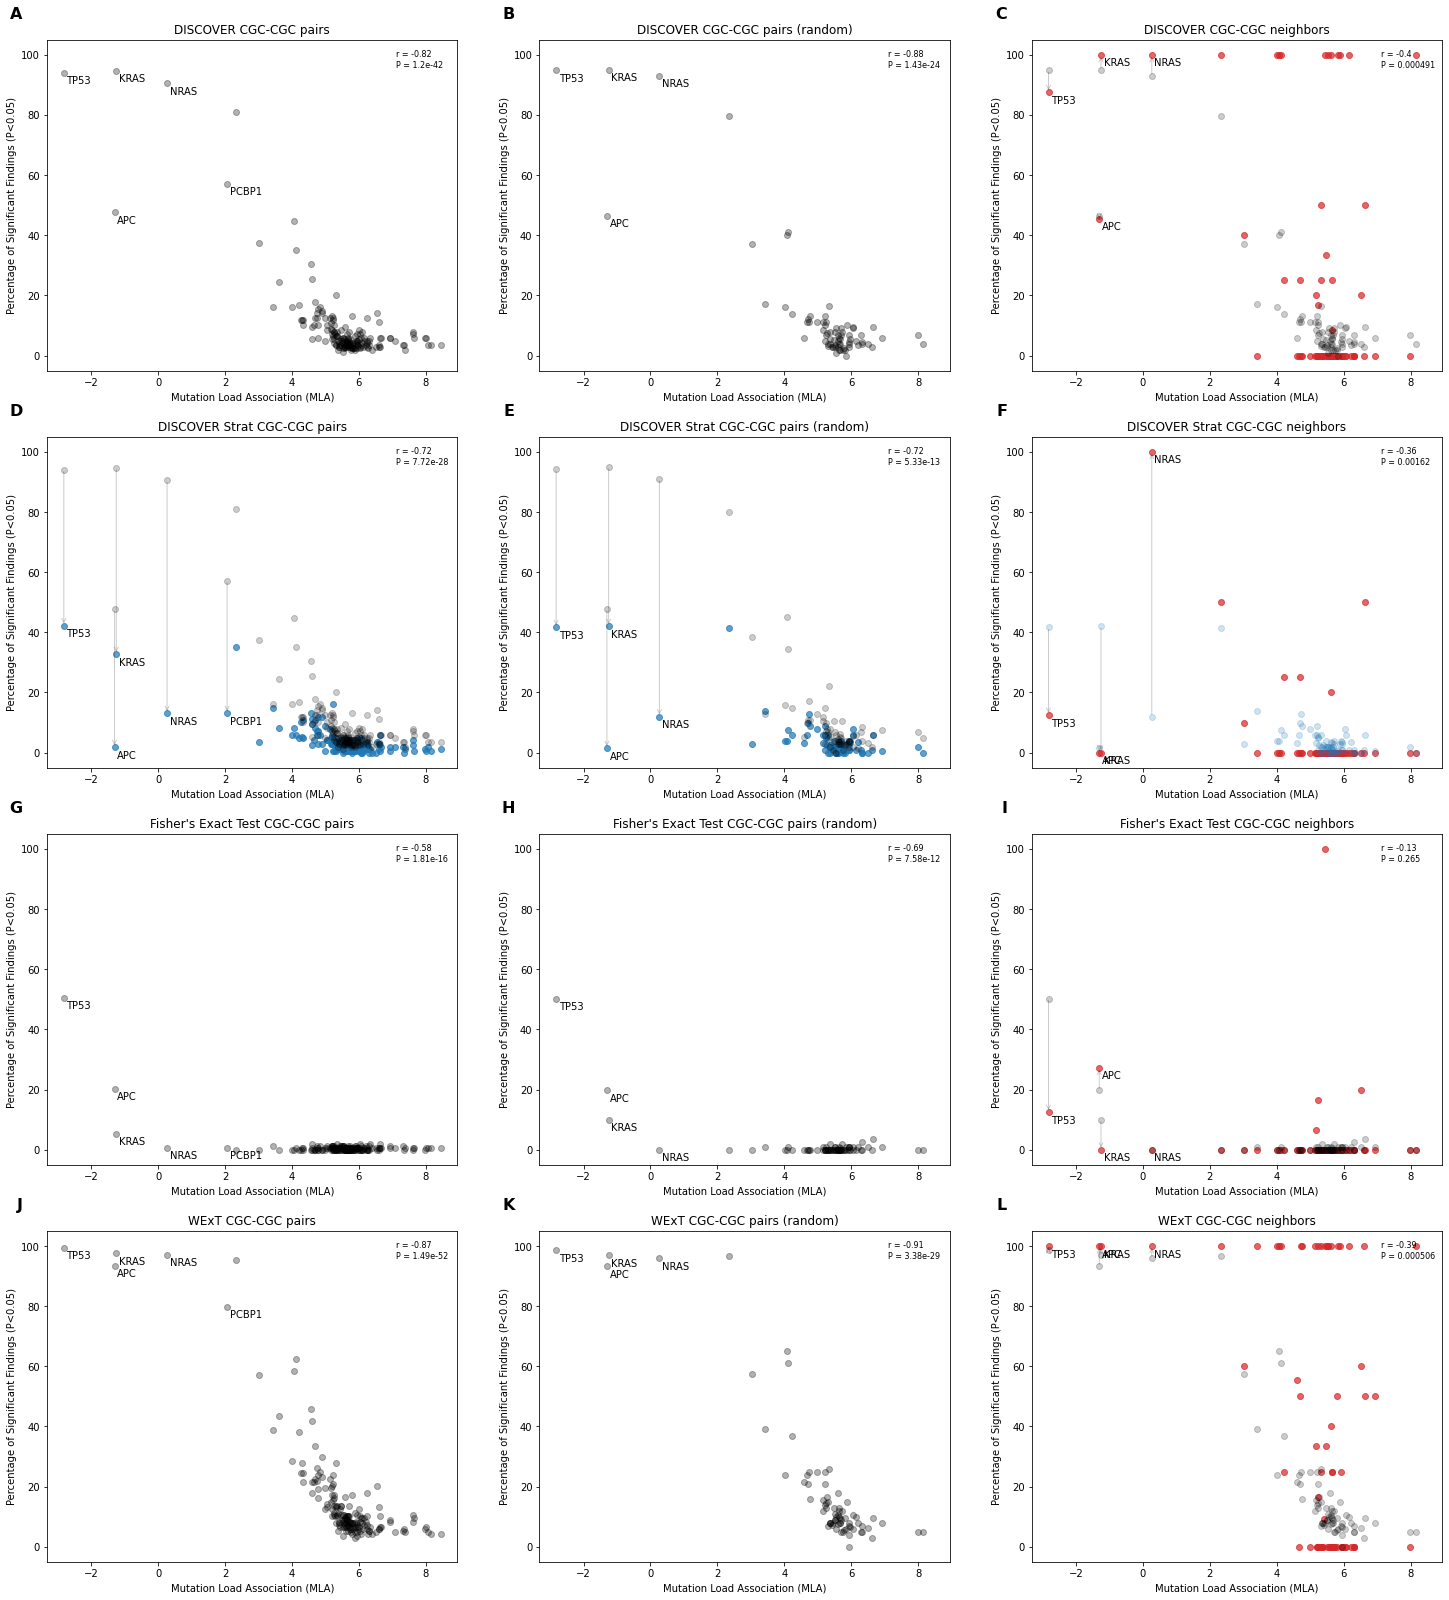

In [22]:
## plot percentage significance

dict_methods = {'discover': 'DISCOVER',
               'discover_strat': 'DISCOVER Strat',
               'fishers': 'Fisher\'s Exact Test',
               'megsa': 'MEGSA',
               'memo': 'MEMO',
               'wext': 'WExT'}


sfx = '../results_main/evaluation_results/figures_v8_random_fig3ep_for paper/'

outpath_cgcg_nb = sfx

if not os.path.exists(outpath_cgcg_nb):
    os.makedirs(outpath_cgcg_nb)

#margins for annotation of genes within plot
#use 1.2,2.2,...,4.2 val_x for different cancer types
val_x = 2.2
val_y = -0.1

fig, axes = plt.subplots(len(methods),3,figsize=(25,28)) #adjust figsize for the plot .for 3 methods: (25,20)
letters = list(string.ascii_uppercase)[:len(methods)*3] #annotate figures alphabetiaclly
axiter=axes.flat #flatten axis to a list
for i,m in tqdm(enumerate(methods)):
    
    if m=='discover_strat':
        dict_sig = get_sig_dict(dict_cg_cg[m],m)
        dict_sig_discover = get_sig_dict(dict_cg_cg['discover'],'discover') #load discover to compare
        dict_sig_rand = get_sig_dict_from_random_sampling(dict_cg_cg[m],dict_cg_cg_nb[m],m) 
        dict_sig_rand_discover = get_sig_dict_from_random_sampling(dict_cg_cg['discover'],dict_cg_cg_nb['discover'],'discover')
        dict_sig_cg_cg_nb = get_sig_dict(dict_cg_cg_nb[m], m)

        #main plot
        max_mla, min_mla = get_mla_limits(dict_sig,MLA)
        ax=axiter[3*i]
        letter=letters[3*i]
        #title = '{} COSMIC-COSMIC pairs'.format(dict_methods[m])
        title = '{} CGC-CGC pairs'.format(dict_methods[m])
        plot_from_dict_arrow(dict_sig_discover,dict_sig,MLA,ax,title=title,c1='C0', annotation_threhsold_x=val_x, annotation_threshold_y=val_y)

        ax.text(-0.06, 1.1, letter, transform=ax.transAxes,
              fontsize=16, fontweight='bold', va='top', ha='right')

        #random sampled plot
        ax=axiter[3*i+1]
        letter=letters[3*i+1]
        #title = '{} COSMIC-COSMIC pairs (random)'.format(dict_methods[m])
        title = '{} CGC-CGC pairs (random)'.format(dict_methods[m])
        plot_from_dict_arrow(dict_sig_rand_discover,dict_sig_rand,MLA,ax,title=title,c1='C0', annotation_threhsold_x=val_x, annotation_threshold_y=val_y)

        ax.text(-0.06, 1.1, letter, transform=ax.transAxes,
              fontsize=16, fontweight='bold', va='top', ha='right')
        
        #neighbors plot
        ax=axiter[3*i+2]
        letter=letters[3*i+2]
        #title = '{} COSMIC-COSMIC neighbors'.format(dict_methods[m])
        title = '{} CGC-CGC neighbors'.format(dict_methods[m])
        plot_from_dict_arrow(dict_sig_rand,dict_sig_cg_cg_nb,MLA,ax,title=title,c2='C0', annotation_threhsold_x=val_x, annotation_threshold_y=val_y)

        ax.text(-0.06, 1.1, letter, transform=ax.transAxes,
              fontsize=16, fontweight='bold', va='top', ha='right')
    
    else:
        dict_sig = get_sig_dict(dict_cg_cg[m], m)
        dict_sig_rand = get_sig_dict_from_random_sampling(dict_cg_cg[m],dict_cg_cg_nb[m],m)
        dict_sig_cg_cg_nb = get_sig_dict(dict_cg_cg_nb[m], m)

        #main plot
        max_mla, min_mla = get_mla_limits(dict_sig,MLA)
        ax=axiter[3*i]
        letter=letters[3*i]
        #title = '{} COSMIC-COSMIC pairs'.format(dict_methods[m])
        title = '{} CGC-CGC pairs'.format(dict_methods[m])
        plot_from_dict(dict_sig,MLA,ax,title=title,annotation_threhsold_x=val_x,annotation_threshold_y=val_y)

        ax.text(-0.06, 1.1, letter, transform=ax.transAxes,
              fontsize=16, fontweight='bold', va='top', ha='right')

        #randomized plot
        ax=axiter[3*i+1]
        letter=letters[3*i+1]
        #title = '{} COSMIC-COSMIC pairs (random)'.format(dict_methods[m])
        title = '{} CGC-CGC pairs (random)'.format(dict_methods[m])
        plot_from_dict(dict_sig_rand,MLA,ax,title=title,annotation_threhsold_x=val_x,annotation_threshold_y=val_y)
        ax.text(-0.06, 1.1, letter, transform=ax.transAxes,
              fontsize=16, fontweight='bold', va='top', ha='right')
         
        ax=axiter[3*i+2]
        letter=letters[3*i+2]
        #title = '{} COSMIC-COSMIC neighbors'.format(dict_methods[m])
        title = '{} CGC-CGC neighbors'.format(dict_methods[m])
        plot_from_dict_arrow(dict_sig_rand,dict_sig_cg_cg_nb,MLA,ax,title=title, annotation_threhsold_x=val_x, annotation_threshold_y=val_y)

        ax.text(-0.06, 1.1, letter, transform=ax.transAxes,
              fontsize=16, fontweight='bold', va='top', ha='right')

plt.savefig(outpath_cgcg_nb+'{}_t{}_percsig_random_fig1.pdf'.format(c,t),format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
len(dict_cgcg_intact[m]),len(dict_sig_rand)

NameError: ignored

## Testing individual genes - a separate section for testing select genes and their properties

In [ ]:
binary_inpath = '../mutex_data/binary_matrices_all_genes_ep_mutation_filtered/'
binary_infile = binary_inpath + '{}_TML_binary_sm.txt'.format(c)

df = pd.read_csv(binary_infile, sep='\t', header=0,index_col=0)

genes=df.columns.tolist()

dict_gene_vs_patients = {}

for g in genes:
    dict_gene_vs_patients[g]=df.index[df[g] == 1].tolist()
    
dict_gene_vs_patients

{'A1BG': ['TCGA-FD-A62P-01A',
  'TCGA-G2-A3IE-01A',
  'TCGA-GC-A3I6-01A',
  'TCGA-SY-A9G5-01A'],
 'A1CF': ['TCGA-FJ-A3ZF-01A', 'TCGA-GU-A767-01A', 'TCGA-XF-A9SV-01A'],
 'A2M': ['TCGA-5N-A9KI-01A',
  'TCGA-BL-A3JM-01A',
  'TCGA-BT-A20J-01A',
  'TCGA-BT-A3PJ-01A',
  'TCGA-C4-A0EZ-01A',
  'TCGA-CF-A1HS-01A',
  'TCGA-CF-A47Y-01A',
  'TCGA-FD-A6TD-01A',
  'TCGA-G2-A3IB-01A',
  'TCGA-G2-A3VY-01A',
  'TCGA-K4-A4AC-01A',
  'TCGA-MV-A51V-01A',
  'TCGA-XF-A9SI-01A',
  'TCGA-XF-A9T6-01A',
  'TCGA-ZF-A9R2-01A'],
 'A2ML1': ['TCGA-DK-A1AC-01A',
  'TCGA-DK-A1AF-01A',
  'TCGA-DK-A2I2-01A',
  'TCGA-DK-A6AW-01A',
  'TCGA-DK-A6B5-01A',
  'TCGA-E5-A2PC-01A',
  'TCGA-H4-A2HQ-01A',
  'TCGA-K4-A83P-01A',
  'TCGA-R3-A69X-01A',
  'TCGA-SY-A9G5-01A',
  'TCGA-XF-A9SY-01A',
  'TCGA-XF-AAMG-01A'],
 'A3GALT2': ['TCGA-ZF-A9RC-01A'],
 'A4GALT': ['TCGA-KQ-A41N-01A'],
 'A4GNT': ['TCGA-DK-AA6L-01A', 'TCGA-DK-AA6U-01A', 'TCGA-K4-A3WS-01A'],
 'AAAS': ['TCGA-FD-A62P-01A', 'TCGA-FD-A6TC-01A', 'TCGA-MV-A51V-01A'],
 'AACS': [

In [ ]:
test_genes = ['SMAD4','SMAD2','SMAD3']
list_vals=[]
m='discover'
for gx in test_genes[:]:
    nbx = len(dict_cg_cg_nb[m][gx])
    patientsx = len(dict_gene_vs_patients[gx])
    
    patientsy_union = set()
    patientsy_intersection= set()
    sig_count=0
    for i,gy in enumerate(dict_cg_cg_nb[m][gx]):
        if dict_cg_cg_nb[m][gx][gy]<0.05:
            sig_count+=1
        if i==0:
            patientsy_intersection = set(dict_gene_vs_patients[gy])
        else:
            patientsy_intersection.intersection(set(dict_gene_vs_patients[gy]))
        
        patientsy_union.update(dict_gene_vs_patients[gy])
    
        
    print(dict_cg_cg_nb[m][gx], nbx,sig_count, patientsx, len(patientsy_union),len(patientsy_intersection))
    list_vals.append([gx,nbx,sig_count, patientsx])#,len(patientsy_union),len(patientsy_intersection)])

cols = ['gene','neighbors', 'sig_nb','patients']
# 'union_neighbor_patients','intersection_neighbor_patients']

df_test = pd.DataFrame(list_vals,columns=cols)
df_test

KeyError: ignored

In [ ]:
s = set()
for i,gx in enumerate(test_genes[:]):
    s2=set()
    for j,gy in enumerate(dict_cg_cg_nb[m][gx]):
        s2.update(dict_gene_vs_patients[gy])
    print(len(s2))
    
    if i==0:
        s.update(s2)
    else:
        s.intersection_update(s2)

len(s)
    

39
380
126


26

In [ ]:
for gx in test_genes:
    print(gx,':',list(dict_cg_cg_nb[m][gx]))

SMAD4 : ['SMAD3', 'SMAD2']
SMAD2 : ['SMAD4', 'TP53', 'SMAD3', 'GNAS', 'TPR', 'MYO5A', 'PREX2', 'CREBBP', 'EP300', 'UBR5']
SMAD3 : ['SMAD4', 'SMAD2', 'SETD2', 'FLNA']


2.995732273553991